In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

%matplotlib inline

In [26]:
HEAD_PATH = '/kaggle/input/coughing-frames/'

In [27]:
df = pd.read_csv(HEAD_PATH + 'frames_label.csv')
df = df.fillna(0)
df.head()

,file,label
0,./frames/S001_v001/S001_v001_frame_1.jpg,0.0
1,./frames/S001_v001/S001_v001_frame_2.jpg,0.0
2,./frames/S001_v001/S001_v001_frame_3.jpg,0.0
3,./frames/S001_v001/S001_v001_frame_4.jpg,0.0
4,./frames/S001_v001/S001_v001_frame_5.jpg,0.0


In [28]:
SPLIT_INDEX = 13768 # set to video 18-20

train_df = df.iloc[0:SPLIT_INDEX]
test_df = df.iloc[SPLIT_INDEX:]

In [29]:
del df

In [30]:
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

Text(0.5, 1.0, 'test_df')

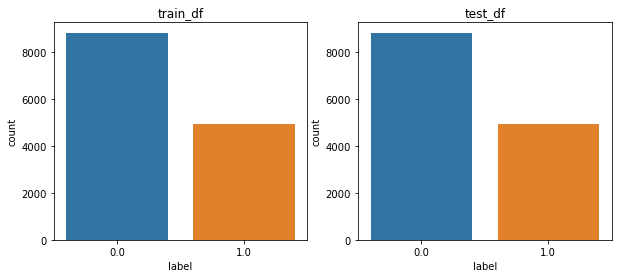

In [31]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.countplot(train_df['label'])
plt.title('train_df')

plt.subplot(1,2,2)
sns.countplot(train_df['label'])
plt.title('test_df')

In [32]:
from keras.preprocessing import image

def create_balance_df(train_df):
    not_cough_indices = train_df[train_df['label'] == 0].index
    random_indices = np.random.choice(not_cough_indices, train_df[train_df['label'] == 1]['label'].count(), replace=False)
    not_cough_sample = train_df.loc[random_indices]

    train_df = train_df[train_df['label'] == 1].append(not_cough_sample)
    return train_df

def get_image_array(file_list):
    image_list = []

    for file in file_list:
        file = HEAD_PATH + 'frames/' + file[2:]
        im = image.load_img(file, target_size=(112, 112, 3))
        im = image.img_to_array(im)
        im = im/255
        image_list.append(im)
        
    image_list = np.array(image_list)
    return image_list

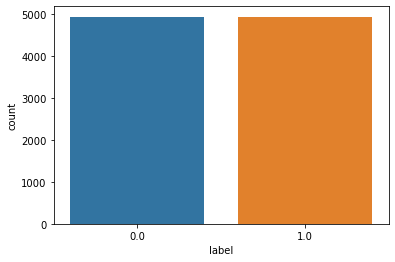

In [33]:
train_df = create_balance_df(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
sns.countplot(train_df['label'])

In [34]:
train_X, train_y = train_df['file'], train_df['label']
test_X, test_y = test_df['file'], test_df['label']

del train_df
del test_df

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(9886,) (9886,) (2136,) (2136,)


In [35]:
train_X = get_image_array(train_X)
train_X.shape

(9886, 112, 112, 3)

In [36]:
from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)

In [37]:
train_X = base_model.predict(train_X)
train_X.shape

(9886, 4, 4, 2048)

In [38]:
shape = train_X.shape[1] * train_X.shape[2] * train_X.shape[3]

In [39]:
train_X = train_X.reshape(train_X.shape[0], shape)
train_X = train_X/train_X.max()
train_X.shape

(9886, 32768)

In [40]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

#defining the model architecture
model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(shape,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [41]:
from keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [42]:
# compiling the model
model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              33555456  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [43]:
model.fit(train_X, train_y, epochs=200, validation_split=0.2, callbacks=[mcp_save], batch_size=128)

Epoch 1/200
62/62 [==============================] - 2s 40ms/step - loss: 0.7148 - accuracy: 0.5019 - val_loss: 0.6939 - val_accuracy: 0.4899
Epoch 2/200
62/62 [==============================] - 2s 34ms/step - loss: 0.6969 - accuracy: 0.4976 - val_loss: 0.6929 - val_accuracy: 0.5101
Epoch 3/200
62/62 [==============================] - 1s 20ms/step - loss: 0.6948 - accuracy: 0.4906 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 4/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6937 - accuracy: 0.4958 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 5/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6934 - accuracy: 0.5044 - val_loss: 0.6931 - val_accuracy: 0.5233
Epoch 6/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6933 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 7/200
62/62 [==============================] - 1s 18ms/step - loss: 0.6933 - accuracy: 0.5095 - val_loss: 0.6932 - val_accuracy: 0.4899
Epoch 

62/62 [==============================] - 1s 20ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4899
Epoch 59/200
62/62 [==============================] - 1s 18ms/step - loss: 0.6931 - accuracy: 0.4976 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 60/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.4976 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 61/200
62/62 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.4966 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 62/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 63/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4899
Epoch 64/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.5073 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 65/200

62/62 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 116/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4899
Epoch 117/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.4982 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 118/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.4995 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 119/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.4980 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 120/200
62/62 [==============================] - 1s 19ms/step - loss: 0.6932 - accuracy: 0.5037 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 121/200
62/62 [==============================] - 1s 18ms/step - loss: 0.6931 - accuracy: 0.4991 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 

Epoch 172/200
62/62 [==============================] - 1s 18ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 173/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 174/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 175/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 176/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 177/200
62/62 [==============================] - 1s 17ms/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6933 - val_accuracy: 0.4899
Epoch 178/200
62/62 [==============================] - 1s 16ms/step - loss: 0.6931 - accuracy: 0.5013 - val_loss: 0.6932 - val_accuracy:

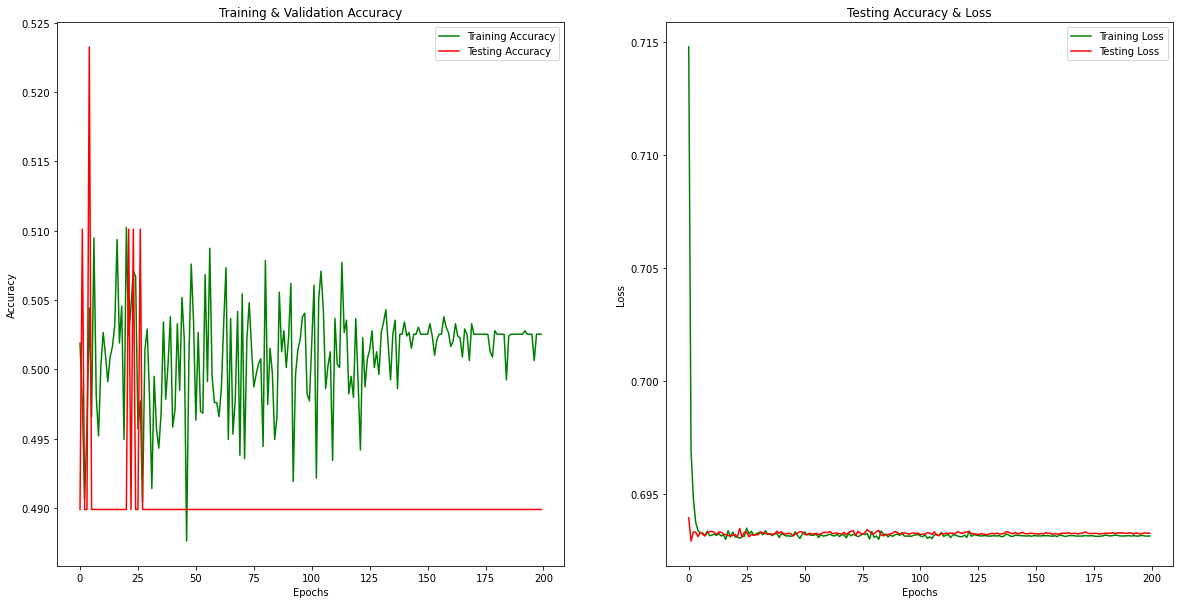

In [44]:
epochs = [i for i in range(len(model.history.history['val_loss']))]
fig , ax = plt.subplots(1,2)
train_acc = model.history.history['accuracy']
train_loss = model.history.history['loss']
val_acc = model.history.history['val_accuracy']
val_loss = model.history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'g-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'r-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-' , label = 'Testing Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [45]:
test_X = get_image_array(test_X)
test_X = base_model.predict(test_X)
test_X = test_X.reshape(test_X.shape[0], shape)
test_X = test_X/train_X.max()

In [46]:
print("Loss of the model is - " , model.evaluate(test_X,test_y)[0])
print("Accuracy of the model is - " , model.evaluate(test_X,test_y)[1]*100 , "%")

67/67 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.6512
Loss of the model is -  0.6915092468261719
67/67 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.6512
Accuracy of the model is -  65.12172222137451 %
